In [1]:
import torch
import torch.nn as nn

from torch import Tensor
from torchsummary import summary

import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms as T
from torchvision.transforms import Compose, Resize, ToTensor

from torch.utils.data import DataLoader
from torch.utils.data import sampler

In [2]:
import os
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

In [4]:
%pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.4 MB/s eta 0:00:00


# Load MNIST Dataset

In [6]:
transform = T.Compose([
    T.ToTensor()
])

dataset_train = datasets.MNIST('dataset', train=True, download=True, transform=transform)
dataset_test = datasets.MNIST('dataset', train=False, download=True, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [7]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

torch.Size([1, 1, 28, 28])


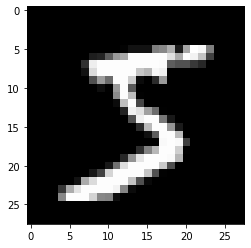

In [8]:
x = dataset_train[0][0]

plt.imshow(x[0], cmap='gray')
x = x.unsqueeze(0)
print(x.shape)

# Image Embedding

In [9]:
class image_embedding(nn.Module):
  def __init__(self, in_channels:int=3, img_size:int=224, patch_size:int=16, emb_dim:int=16*16*3):
    super(image_embedding, self).__init__() 

    self.patch_size = patch_size
    self.linear = nn.Linear(in_channels * patch_size * patch_size, emb_dim)

    # BERT에서 나온 아이디어를 바탕으로 사진의 분류에 관한 정보를 담을 cls_token을 input의 맨 처음 token으로 넣는다.
    self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

    n_patches = (img_size * img_size) // (patch_size ** 2)

    # Positional encoding 시 cls_token을 고려하여 n_patches + 1
    self.positions = nn.Parameter(torch.randn(n_patches + 1, emb_dim))
    
  def forward(self, x):
    batch_size, channels, num_w, num_h = x.shape[0], x.shape[1], x.shape[2] // self.patch_size, x.shape[3] // self.patch_size

    # shape of x: (b, c, (w * p), (h * p)) => (b, c, w, p, h, p)
    x = torch.reshape(x, (batch_size, channels, num_w, self.patch_size, num_h, self.patch_size))

    # shape of x: (b, c, w, p, h, p) => (b, (w * h), (p * p * c))
    x = x.permute(0, 2, 4, 1, 3, 5)

    x = torch.reshape(x, (batch_size, (num_w * num_h), (self.patch_size * self.patch_size * channels)))

    x = self.linear(x)
    
    c = self.cls_token.repeat(batch_size, 1, 1)
    x = torch.cat([c, x], dim=1)

    x = x + self.positions

    return x

# Test
emb = image_embedding(1, 28, 4, 4*4)(x)

# (7 * 7 + 1) patches
print(emb.shape)

torch.Size([1, 50, 16])


# Multi-Head Attention

In [10]:
class multi_head_attention(nn.Module):
  def __init__(self, emb_dim:int=16*16*3, num_heads:int=8, dropout_ratio:float=0.2, verbose=False, **kwargs):
    super(multi_head_attention, self).__init__()
    
    self.v = verbose

    self.emb_dim = emb_dim
    self.num_heads = num_heads
    
    # square root of the dimension of key(d_k)
    self.scaling = (self.emb_dim // num_heads) ** -0.5
    
    self.query = nn.Linear(emb_dim, emb_dim)
    self.key = nn.Linear(emb_dim, emb_dim)
    self.value = nn.Linear(emb_dim, emb_dim)

    self.att_drop = nn.Dropout(dropout_ratio)

    self.linear = nn.Linear(emb_dim, emb_dim)

  def forward(self, x:Tensor) -> Tensor:
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    if self.v:
      print(Q.size(), K.size(), V.size())

    batch_size, num_patches, head_dim = x.shape[0], x.shape[1], x.shape[2] // self.num_heads
    
    # shape of Q: (b, p, (h * d)) -> (b, h, p, d)
    Q = torch.reshape(Q, (batch_size, num_patches, self.num_heads, head_dim))
    Q = Q.permute(0, 2, 1, 3)
    
    # shape of K: (b, p, (h * d)) -> (b, h, d, p)
    K = torch.reshape(K, (batch_size, num_patches, self.num_heads, head_dim))
    K = K.permute(0, 2, 3, 1)
    
    # shape of V: (b, p, (h * d)) -> (b, h, p, d)
    V = torch.reshape(V, (batch_size, num_patches, self.num_heads, head_dim))
    V = V.permute(0, 2, 1, 3)


    if self.v:
      print(Q.size(), K.size(), V.size())

    weight = torch.matmul(Q, K)
    weight = weight * self.scaling
    
    if self.v:
      print(weight.size())

    attention = torch.softmax(weight, dim=-1)
    attention = self.att_drop(attention)

    if self.v:
      print(attention.size())

    context = torch.matmul(attention, V)
    # shape of context: (b, h, p, d) => (b, p, (h * d))
    context = context.permute(0, 2, 1, 3)
    context = torch.reshape(context, (batch_size, num_patches, -1))
    
    if self.v:
      print(context.size())

    x = self.linear(context)
    return x, attention

feat, att = multi_head_attention(4*4, 4, verbose=True)(emb)
print('shape of feat:', feat.shape, 'shape of att:', att.shape)

torch.Size([1, 50, 16]) torch.Size([1, 50, 16]) torch.Size([1, 50, 16])
torch.Size([1, 4, 50, 4]) torch.Size([1, 4, 4, 50]) torch.Size([1, 4, 50, 4])
torch.Size([1, 4, 50, 50])
torch.Size([1, 4, 50, 50])
torch.Size([1, 50, 16])
shape of feat: torch.Size([1, 50, 16]) shape of att: torch.Size([1, 4, 50, 50])


# MLP Block

In [11]:
class mlp_block(nn.Module):
  def __init__(self, emb_dim:int=16*16*3, forward_dim:int=4, dropout_ratio:float=0.2, **kwargs):
    super(mlp_block, self).__init__()

    self.linear_1 = nn.Linear(emb_dim, forward_dim * emb_dim)
    self.dropout = nn.Dropout(dropout_ratio)
    self.linear_2 = nn.Linear(forward_dim * emb_dim, emb_dim)

  def forward(self, x):
    x = self.linear_1(x)
    x = nn.functional.gelu(x)
    x = self.dropout(x)
    x = self.linear_2(x)

    return x

# Transformer Encoder

In [12]:
class encoder_block(nn.Sequential):
  def __init__(self, emb_dim:int=16*16*3, num_heads:int=8, forward_dim:int=4, dropout_ratio:float=0.2):
    super(encoder_block, self).__init__()

    self.norm_1 = nn.LayerNorm(emb_dim)
    self.mha = multi_head_attention(emb_dim, num_heads, dropout_ratio)

    self.norm_2 = nn.LayerNorm(emb_dim)
    self.mlp = mlp_block(emb_dim, forward_dim, dropout_ratio)

    self.residual_dropout = nn.Dropout(dropout_ratio)

  def forward(self, x):
    x_ = self.norm_1(x)
    x_, attention = self.mha(x_)
    x = x_ + self.residual_dropout(x)

    x_ = self.norm_2(x)
    x_ = self.mlp(x_)
    x = x_ + self.residual_dropout(x)

    return x, attention

# Test
feat, att = encoder_block(4*4, 2, 4)(emb)
feat.shape, att.shape

(torch.Size([1, 50, 16]), torch.Size([1, 2, 50, 50]))

# Model

In [13]:
class vision_transformer(nn.Module):
  def __init__(self, in_channel:int=3, img_size:int=224, patch_size:int=16, emb_dim:int=16*16*3,
               n_enc_layers:int=15, num_heads:int=3, forward_dim:int=4, dropout_ratio:float=0.2,
               n_classes:int=1000):
    
    super(vision_transformer, self).__init__()
    self.image_emb = image_embedding(in_channel, img_size, patch_size, emb_dim)
    self.transformer_encoders = nn.ModuleList([encoder_block(emb_dim, num_heads, forward_dim, dropout_ratio) for _ in range(n_enc_layers)])
    
    self.normalization = nn.LayerNorm(emb_dim)
    self.classification_head = nn.Linear(emb_dim, n_classes)

  def forward(self, x):
    x = self.image_emb(x)

    attentions = []
    for encoder in self.transformer_encoders:
      x, att = encoder(x)
      attentions.append(att)

    # shape of x: (b, p, e)
    x = torch.mean(x, dim=1)
    x = self.normalization(x)
    x = self.classification_head(x)

    return x, attentions

# Test
y, att = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)(x)
y.shape, att[0].shape

(torch.Size([1, 10]), torch.Size([1, 2, 50, 50]))

# Train

In [18]:
model = vision_transformer(1, 28, 4, 4*4, 3, 2, 4, 0.2, 10)
model.to(device)

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 64
dataloaders_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(0, len(dataset_train) * 4 // 5)))
dataloaders_valid = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler.SubsetRandomSampler(range(len(dataset_train) * 4 // 5, len(dataset_train))))
dataloaders_test = DataLoader(dataset_test, batch_size=batch_size)

In [19]:
for epoch in range(num_epochs):
  print('--- Epoch {} ---'.format(epoch))

  model.train()
  training_loss, training_acc = 0.0, 0.0

  num_samples = 0

  for idx, (inputs, labels) in enumerate(dataloaders_train):
    inputs = inputs.to(device)
    labels = labels.to(device)
    num_samples += inputs.shape[0]

    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      outputs, attentions = model(inputs)
      max_val, preds = torch.max(outputs, dim=-1)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      training_loss += loss.item() * inputs.shape[0]
      training_acc += torch.sum(preds == labels.data)

    
  # training_acc /= (idx + 1) * batch_size
  training_acc /= num_samples

  print('{} Loss: {:.4f} | Acc: {:.4f}'.format('train', training_loss, training_acc))

  model.eval()

  training_acc = 0.0
  num_samples = 0

  for idx, (inputs, labels) in enumerate(dataloaders_valid):
    inputs = inputs.to(device)
    labels = labels.to(device)
    num_samples += inputs.shape[0]

    with torch.set_grad_enabled(False):
      outputs, _ = model(inputs)
      max_val, preds = torch.max(outputs, dim=-1)

      training_acc += torch.sum(preds == labels.data)

  training_acc /= num_samples
  print('{} Acc: {:.4f}'.format('valid', training_acc))

--- Epoch 0 ---
train Loss: 78786.2411 | Acc: 0.3921
valid Acc: 0.6788
--- Epoch 1 ---
train Loss: 37441.2483 | Acc: 0.7433
valid Acc: 0.8151
--- Epoch 2 ---
train Loss: 27266.6384 | Acc: 0.8221
valid Acc: 0.8705
--- Epoch 3 ---
train Loss: 23380.0846 | Acc: 0.8481
valid Acc: 0.8885
--- Epoch 4 ---
train Loss: 21146.5052 | Acc: 0.8646
valid Acc: 0.8931
--- Epoch 5 ---
train Loss: 19709.5432 | Acc: 0.8720
valid Acc: 0.9010
--- Epoch 6 ---
train Loss: 18638.0017 | Acc: 0.8769
valid Acc: 0.9022
--- Epoch 7 ---
train Loss: 17610.1768 | Acc: 0.8847
valid Acc: 0.9019
--- Epoch 8 ---
train Loss: 16800.9080 | Acc: 0.8894
valid Acc: 0.9103
--- Epoch 9 ---
train Loss: 16191.1251 | Acc: 0.8941
valid Acc: 0.9149


In [21]:
model.eval()
test_acc = 0.0

num_samples = 0

for idx, (inputs, labels) in enumerate(dataloaders_test):
  inputs = inputs.to(device)
  labels = labels.to(device)
  num_samples += inputs.shape[0]

  with torch.set_grad_enabled(True):
    outputs, attentions = model(inputs)
    max_val, preds = torch.max(outputs, dim=-1)
    
    test_acc += torch.sum(preds == labels.data)

test_acc /= num_samples
print('{} Acc: {:.4f}\n'.format('test', test_acc))

test Acc: 0.9149



# Visualization of Attention

https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb

shape of input image: torch.Size([1, 1, 28, 28])
number of encoders: 3
shape of attention: torch.Size([1, 2, 50, 50])
shape of input image: torch.Size([1, 1, 28, 28])
number of encoders: 3
shape of attention: torch.Size([1, 2, 50, 50])
shape of input image: torch.Size([1, 1, 28, 28])
number of encoders: 3
shape of attention: torch.Size([1, 2, 50, 50])
shape of input image: torch.Size([1, 1, 28, 28])
number of encoders: 3
shape of attention: torch.Size([1, 2, 50, 50])
shape of input image: torch.Size([1, 1, 28, 28])
number of encoders: 3
shape of attention: torch.Size([1, 2, 50, 50])


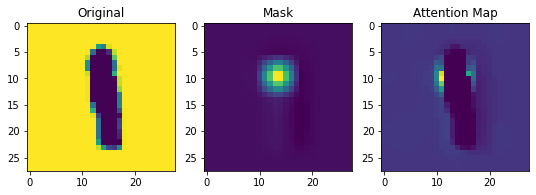

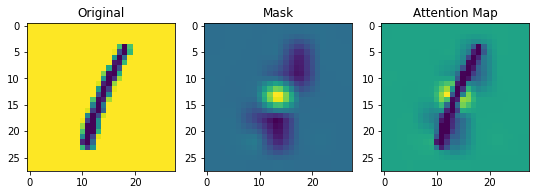

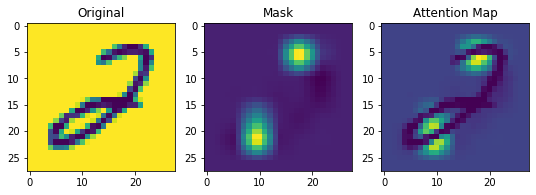

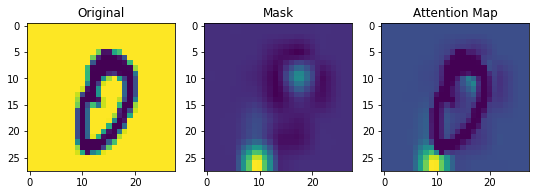

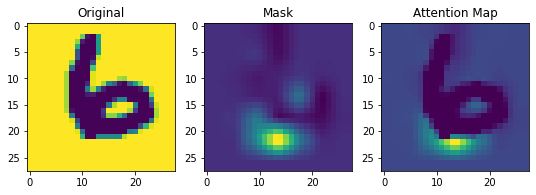

In [39]:
indices = np.random.choice(range(len(dataset_test.data)), 5, False)

for idx in indices:
  img = dataset_test.data[idx]
  img = 255 - img
  x = img.unsqueeze(0).unsqueeze(1).to(device, torch.float)
  print('shape of input image:', x.shape)

  _, attentions = model(x)
  print('number of encoders:', len(attentions))
  print('shape of attention:', attentions[0].shape)
  
  # shape of att_mat: 3 * (b, h, len1, len2) => (e, b, h, len1, len2) => (e, h, len1, len2)
  att_mat = torch.stack(attentions).squeeze(1) 
  att_mat = att_mat.detach().cpu()
  
  # shape of att_mat: (e, h, len1, len2) => (e, len1, len2)
  att_mat = torch.mean(att_mat, dim=1)

  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  joint_attentions = torch.zeros(aug_att_mat.size())
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

  v = joint_attentions[-1]
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  mask = cv2.resize(mask / mask.max(), (img.shape[1], img.shape[0]))[..., None]
  mask = mask.squeeze()
  result = (mask * img.numpy()).astype("uint8")

  # plotting
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9, 3)) 
  ax1.set_title('Original')
  ax2.set_title('Mask')
  ax3.set_title('Attention Map')
  _ = ax1.imshow(img)
  _ = ax2.imshow(mask)
  _ = ax3.imshow(result)